In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math
import importlib

import dual_enc_dec_cnmp as dual_enc_dec_cnmp
import utils
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

#params = np.array([[2,0],[2,0],[2,0],[2,0],[2,0],[-0.6,0.1],[-0.55, 0.16],[-0.5,0.23],[-0.45, 0.33],[-0.4,0.43]])
#params = np.array([[20],[19.9],[19.7]])

#num_demo = 128
#X1, X2, Y1, Y2, validation_Y1, validation_Y2 = utils.generate_demonstrations(num_demo, time_len=200, params = params, plot_title='Training')

Y1 = np.load("forward_trajectories_downsampled.npy")
Y2 = np.load("inverse_trajectories_downsampled.npy")

Y1 = Y1[:,:,[0,1,2,3,4,5,6,13,14,15,16]]
Y2 = Y2[:,:,[0,1,2,3,4,5,6,13,14,15,16]]

num_demo = Y1.shape[0]
X1 = np.linspace(0, 1, Y1.shape[1]).reshape(1, -1, 1)
X2 = np.linspace(0, 1, Y2.shape[1]).reshape(1, -1, 1)

In [182]:

valid_inverses = [True for i in range(num_demo)]
demo_data = [X1, X2, Y1, Y2]
d_x = X1.shape[2]
d_y1 = Y1.shape[2]
d_y2 = Y2.shape[2]
OBS_MAX = 15
d_N = num_demo
time_len = Y1.shape[1]

validation_indices_1 = [i+1 for i in range(0, 64-1, 7)]
validation_indices_2 = [i+2 for i in range(0, 64-2, 7)]
validation_indices = validation_indices_1 + validation_indices_2

## convert to tensor, use sourceTensor.clone().detach() to get a new tensor
X1 = torch.tensor(X1, dtype=torch.float32)
X2 = torch.tensor(X2, dtype=torch.float32)
Y1 = torch.tensor(Y1, dtype=torch.float32)
Y2 = torch.tensor(Y2, dtype=torch.float32)


/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_57335/3691653601.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X1 = torch.tensor(X1, dtype=torch.float32)
/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_57335/3691653601.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X2 = torch.tensor(X2, dtype=torch.float32)
/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_57335/3691653601.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y1 = torch.tensor(Y1, dtype=torch.float32)
/var/folders/63/kw9gvntx3hzf

In [183]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)


errors = []
losses = []
errors_with_latent = []


def train():

    model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def lr_lambda(epoch):
        if epoch < 10000:
            return 1e-3 / optimizer.defaults['lr']  # Scale factor for 1e-3
        elif epoch < 40000:
            return 1e-4 / optimizer.defaults['lr']  # Scale factor for 1e-4
        elif epoch < 100000:
            return 1e-5 / optimizer.defaults['lr']  # Scale factor for 1e-5
        else:
            return 1e-6 / optimizer.defaults['lr']
    
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    error = 0

    unpaired_traj = False
    
    for i in range(EPOCHS):

        if i == 0:
            unpaired_traj = True
    
        obs, mask, x_tar, y_tar_f, y_tar_i, traj_indices = dual_enc_dec_cnmp.get_training_sample(validation_indices, valid_inverses, unpaired_traj, X1, Y1, X2, Y2, OBS_MAX, d_N, d_x, d_y1, d_y2, time_len)
        optimizer.zero_grad()
        output, L_F, L_I = model(obs, mask, x_tar)

        loss = dual_enc_dec_cnmp.loss(output, y_tar_f, y_tar_i, d_y1, d_y2, L_F.squeeze(1), L_I.squeeze(1), valid_inverses, traj_indices)
        loss.backward()

        optimizer.step()
        scheduler.step()

        # VALIDATION
        if i % 100 == 0:
            #print(f"epoch {i}, loss: {loss.item()}")
            #utils.plot_latent_tsne(model, Y1, Y2, i)
            if i % 1000 == 0:
                print("Epoch: ", i)
                losses.append(loss.item())

                
                # print(f'Epoch: {i}, Loss: {loss.item()}')
                error = 0
                plot_id = np.random.randint(0, len(validation_indices))
                for validation_idx in validation_indices:
                    time = np.linspace(0, 1, time_len)
                    # permute time
                    idx = np.random.permutation(time_len)
                    idx = idx[:10]
                    time = [time[i] for i in idx]
                    condition_points = [[t, Y1[validation_idx, i:i+1]] for t,i in zip(time, idx)]
                    means, stds = dual_enc_dec_cnmp.predict_forward_forward(model, validation_idx, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
                    if i % 1000 == 0 and validation_idx == validation_indices[plot_id]:
                        error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=True)
                    else:
                        error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=False)

                    latent_loss = loss - dual_enc_dec_cnmp.log_prob_loss(output, y_tar_f, y_tar_i, d_y1, d_y2, valid_inverses, traj_indices)
                error_with_latent = error + latent_loss.item()
                errors_with_latent.append(error_with_latent)
                errors.append(error)
                print('loss: ', loss.item()) 
                print(error)
                if errors_with_latent[-1] == min(errors_with_latent):
                    print('Saving model ', i)
                    print('loss: ', loss.item())  
                    print('latent loss: ', latent_loss.item())  
                    torch.save(model.state_dict(), 'inverse_best_model.pth')


In [185]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

EPOCHS = 100000
learning_rate = 1e-4

train()

IndexError: index 50 is out of bounds for dimension 0 with size 50

In [148]:
best_model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2)
best_model.load_state_dict(torch.load('inverse_best_model.pth'))

/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_57335/1488616078.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('invers

<All keys matched successfully>

/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_64491/3596424414.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_observations_f = torch.tensor(all_observations_f)
/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_64491/3596424414.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_observations_i = torch.tensor(all_observations_i)


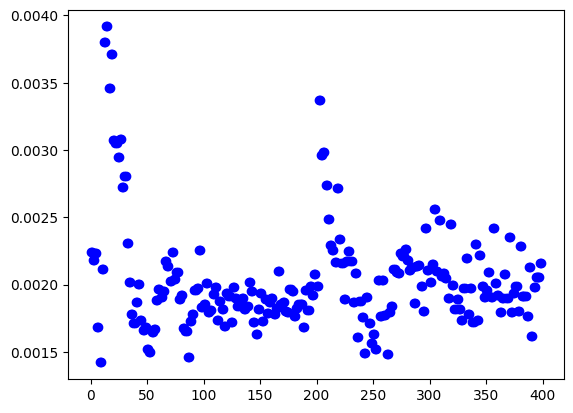

(800, 32)
(800, 2)


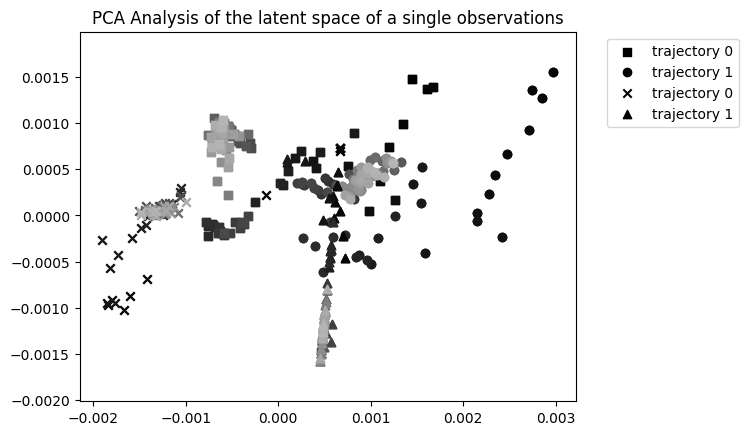

In [ ]:

importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)
from mpl_toolkits.mplot3d import Axes3D
from sympy import intervals


traj_ids = [0, 1]

all_observations_f = torch.zeros(0)
all_observations_i = torch.zeros(0)

NUM_STEP = 200

for t in traj_ids:
    
    interval_y_f = torch.zeros(NUM_STEP, d_y1)
    
    for i in range(NUM_STEP):
        interval_y_f[i] = Y1[t, int(i * time_len / NUM_STEP)]

    interval_y_i = torch.zeros(NUM_STEP, d_y2)

    for i in range(NUM_STEP):
        interval_y_i[i] = Y2[t, int(i * time_len / NUM_STEP)]

    for i in range(NUM_STEP):
        condition_points = torch.concatenate([torch.tensor([t]), interval_y_f[i]])
        all_observations_f = torch.cat((all_observations_f, condition_points.unsqueeze(0)), dim=0)
    
    for i in range(NUM_STEP):
        condition_points = torch.concatenate([torch.tensor([t]), interval_y_i[i]])
        all_observations_i = torch.cat((all_observations_i, condition_points.unsqueeze(0)), dim=0)



all_observations_f = torch.tensor(all_observations_f)
all_observations_i = torch.tensor(all_observations_i)

pca_result = dual_enc_dec_cnmp.plot_latent_space(best_model, all_observations_f, all_observations_i) # [ft0, ft1, ... , it0, it1, ...]

print(pca_result.shape)
pca_result = np.array(pca_result)
pca_result_f1, pca_result_f2, pca_result_i1, pca_result_i2 = pca_result[:NUM_STEP], pca_result[NUM_STEP:NUM_STEP*2], pca_result[NUM_STEP*2:NUM_STEP*3], pca_result[NUM_STEP*3:]

pca_result = np.array([pca_result_f1, pca_result_f2, pca_result_i1, pca_result_i2])

dict_markers = {0:'s', 1:'o', 2:'x', 3:'^'}

for i in range(4):
    for j in range(NUM_STEP):
        if j == 0:
            plt.scatter(pca_result[i, j, 0], pca_result[i, j, 1], marker=dict_markers[i], c=f"{(j)/(1.4*NUM_STEP)}", label=f"trajectory {i%2}")
        else:
            plt.scatter(pca_result[i, j, 0], pca_result[i, j, 1], marker=dict_markers[i], c=f"{(j)/(1.4*NUM_STEP)}")
    plt.title("PCA Analysis of the latent space of a single observations")

plt.axis('equal')
    
## make x and y axis equal

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



[[0, tensor([[ 0.0000, -0.5000,  0.0000,  1.5000,  0.0000,  2.1500,  0.0000,  0.0000,
         -0.3000,  0.3000, -0.3000]])]]


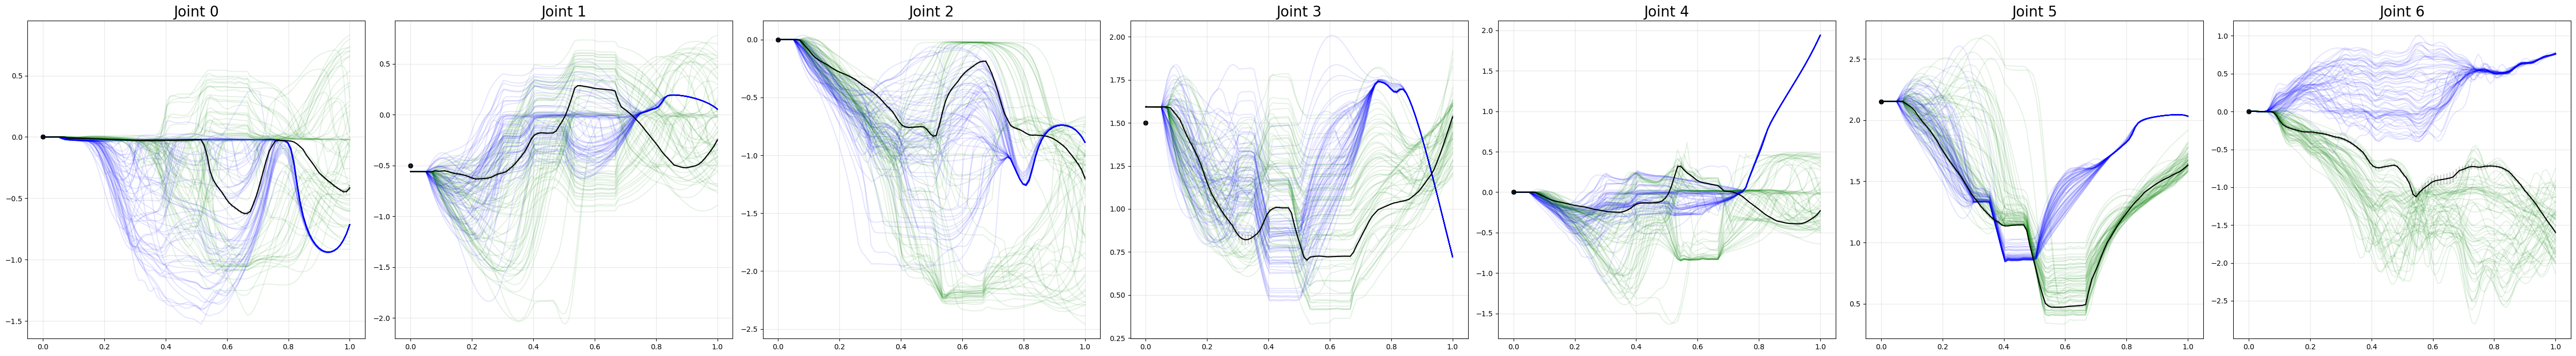

In [154]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)


condition_points = [[0, torch.tensor([[0, -0.5, 0, 1.5, 0, 2.15, 0, 0, -0.3, 0.3, -0.3]])]]
print(condition_points)
means, stds = dual_enc_dec_cnmp.predict_forward_forward(best_model, 1, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
utils.plot_results(means, stds, Y1, Y2, condition_points, time_len, d_N)

In [ ]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

def sinx(frequency, amplitude, phase):
    def dist(x):
        return amplitude * math.sin(2 * torch.pi * frequency * x + phase) # + torch.randn(1) * 0.05
    return dist

t = 0.25
min_y_f = torch.min(Y1[:, int(t * time_len)])
max_y_f = torch.max(Y1[:, int(t * time_len)])
interval_y_f = np.linspace(min_y_f, max_y_f, 200)

frequencies = [1]

NUM_OBS = 1000
amplitudes = np.linspace(0.5, 0.1, NUM_OBS)
    
phases = [0]  # Example phases

t = 0.25
min_y_f = torch.min(Y1[:, int(t * time_len)])
max_y_f = torch.max(Y1[:, int(t * time_len)])
interval_y_f = np.linspace(min_y_f, max_y_f, 5)

min_y_i = torch.min(Y2[:, int(t * time_len)])
max_y_i = torch.max(Y2[:, int(t * time_len)])
interval_y_i = torch.linspace(-0.5, -0.1, NUM_OBS)

# plot latent losses
#plt.plot(errors_with_latent)
#plt.show()

i = 0
mse_list = []
for i in range(len(interval_y_i)):
    condition_points = [[0.25, torch.tensor([interval_y_i[i]])]]
    means, stds = dual_enc_dec_cnmp.predict_forward(best_model, 1, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
    dist = sinx(frequencies[i % len(frequencies)], amplitudes[i], phases[i % len(phases)])
    mse = F.mse_loss(means, torch.tensor([dist(t) for t in np.linspace(0, 1, time_len)]))
    mse_list.append(mse.item())

np.save("mse_0_nounpaired.npy", mse_list)
mse_paired = np.load("mse_0.npy")
plt.plot(interval_y_i, mse_paired, label='Unpaired Training')
plt.plot(interval_y_i, mse_list, label='Standard Training')
plt.grid(alpha=0.3)
plt.ylabel('MSE Loss')
plt.xlabel('Inverse Observation Position')
plt.vlines(-0.4, -1, 20, color='black', label='Min of Paired Data', linestyles='dashed')
plt.ylim(-0.00002, 0.0002)
plt.legend()
plt.xlim(-0.6, 0)
plt.show()

    

In [45]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

t = 0.25
min_y_f = torch.min(Y1[:, int(t * time_len)])
max_y_f = torch.max(Y1[:, int(t * time_len)])
interval_y_f = np.linspace(min_y_f, max_y_f, 20)

min_y_i = torch.min(Y2[:, int(t * time_len)])
max_y_i = torch.max(Y2[:, int(t * time_len)])
interval_y_i = torch.linspace(-0.5, -0.1, 20)

# plot latent losses
#plt.plot(errors_with_latent)
#plt.show()

i = 0
for i in range(len(interval_y_i)):
    condition_points = [[0.25, torch.tensor([interval_y_i[i]])]]
    means, stds = dual_enc_dec_cnmp.predict_inverse_inverse(best_model, 1, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
    if i == 0:
        utils.plot_results_ii(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N, plot_errors = False)
    else:
        utils.plot_results_ii(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N, plot_errors = False)

RuntimeError: The expanded size of the tensor (8) must match the existing size (2) at non-singleton dimension 0.  Target sizes: [8].  Tensor sizes: [2]